In [12]:
#Prerequisites
# !pip install yfinance
# !pip install gplearn

In [13]:
import numpy as np
import pandas as pd

import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from gplearn.genetic import SymbolicRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import HuberRegressor,BayesianRidge,OrthogonalMatchingPursuit
from sklearn.ensemble import VotingRegressor,StackingRegressor

from sklearn.metrics import mean_absolute_error,accuracy_score

In [145]:
def replace_bad(df):
    return df.replace(to_replace=[np.NaN,np.inf,-np.inf],value = 0,inplace=True)

def retrieve_data(SYMBOL,start,stop,window_days):

    stock_data = yf.download(SYMBOL ,start=start,end=stop,progress=False)
 
     
    replace_bad(stock_data)
    stock_data = stock_data[['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']]
    stock_data.columns = ['Open', 'High', 'Low', 'Close','Adj_Close', 'Volume']
    stock_data.drop(['Volume'],axis=1,inplace=True)
    
    Y = pd.DataFrame(stock_data['Adj_Close'].pct_change(periods = window_days).values,columns=[SYMBOL]).shift(-window_days)
    
#     stock_data.columns = [x+'_'+SYMBOL for x in list(stock_data.columns)]

    Y.reset_index(drop =True, inplace =True)
    stock_data.reset_index(drop =True, inplace =True)
    
    df_out_x = stock_data
    
    df_out_y = pd.DataFrame(Y)
    df_out_y_cat = np.where(df_out_y > 0 ,1,0)
    
    replace_bad(df_out_x)
    replace_bad(df_out_y)
    return df_out_x, df_out_y,df_out_y_cat
def shifts(df,window,time_frame):
    for col in df.columns.tolist():
        for i in range(1,window-time_frame):
            df[col+'_'+str(i)] = df[col].pct_change(periods = -1*i).shift(-1*i)
    df.drop(['Open', 'High', 'Low', 'Close','Adj_Close'],axis=1,inplace=True)
    replace_bad(df)
    return df
def categorical(real,pred,sample_weight = 0 ):
    pred = np.where(pred > 0 ,1,0)
    real = np.where(real > 0 ,1,0)
    return accuracy_score(real,pred)
def density(real,pred,sample_weight = 0.5 ):
    pred = pd.Series(np.where(pred > 0 ,1,0).flatten())
    real = pd.Series(np.where(real > 0 ,1,0).flatten())
    pred.plot.kde(bw_method='silverman')
    real.plot.kde(bw_method='silverman')
    plt.show()
def results(real,pred):
    plt.plot(real.values[:-4],c='green')
    plt.plot(pred[:-4])
    plt.tight_layout()
    plt.show()

In [15]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
symbols = table[0]

for i,comp in enumerate(symbols['Symbol'].tolist()):
    if '.' in symbols.loc[i,'Symbol']:
        symbols.loc[i,'Symbol'] = symbols.loc[i,'Symbol'].replace('.','-')
        
invalid_stocks = ['CARR', 'CTVA', 'DOW', 'FOX', 'FOXA', 'HWM', 'OTIS', 'TT', 'VIAC']
Valid_Stock_Indexes = [i for i,x in enumerate(symbols['Symbol']) if symbols.loc[i,'Symbol'] not in invalid_stocks]

symbols = symbols.loc[Valid_Stock_Indexes,:]

In [103]:
pd.Series([1,5]).pct_change(1)

0    NaN
1    4.0
dtype: float64

In [75]:
help(SymbolicRegressor)

Help on class SymbolicRegressor in module gplearn.genetic:

class SymbolicRegressor(BaseSymbolic, sklearn.base.RegressorMixin)
 |  A Genetic Programming symbolic regressor.
 |  
 |  A symbolic regressor is an estimator that begins by building a population
 |  of naive random formulas to represent a relationship. The formulas are
 |  represented as tree-like structures with mathematical functions being
 |  recursively applied to variables and constants. Each successive generation
 |  of programs is then evolved from the one that came before it by selecting
 |  the fittest individuals from the population to undergo genetic operations
 |  such as crossover, mutation or reproduction.
 |  
 |  Parameters
 |  ----------
 |  population_size : integer, optional (default=1000)
 |      The number of programs in each generation.
 |  
 |  generations : integer, optional (default=20)
 |      The number of generations to evolve.
 |  
 |  tournament_size : integer, optional (default=20)
 |      The n

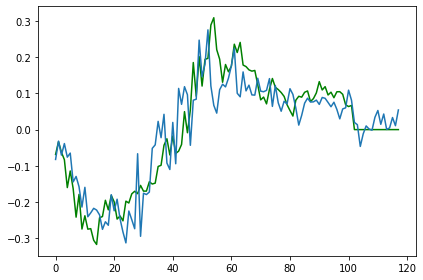

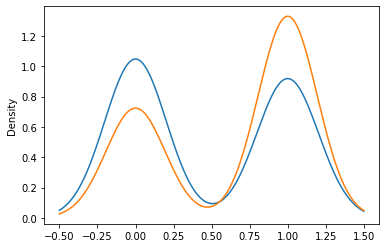

Accuracy: 80.32786885245902 %
MAE: 4.970156800805113 %
-------------------------------------------------------------------------------


In [148]:
start = '2017-10-01'
stop  = '2020-07-28'
#shift_window is how much past data you want to inform the model with
#shift_window > time, shift_window > time by at least 2 days
shift_window_of_days = 40
#time is constant
time = 20
# for symbol in symbols['Symbol'].tolist():
symbol = 'MMM'
X,target,cat_target = retrieve_data(symbol,start,stop,shift_window_of_days)
X = shifts(X,shift_window_of_days,time)

X_train,X_test,Y_train,Y_test = train_test_split(X,target,test_size=0.2,shuffle=False)
future_feature = X_test.head(shift_window_of_days - time)

# SYMB = SymbolicRegressor(init_method = 'full',function_set = ['add', 'sub', 'mul', 'div','max'],n_jobs =1)
HR = HuberRegressor(max_iter=6000)
BR = BayesianRidge()
OMP = OrthogonalMatchingPursuit()
voter = VotingRegressor(estimators=[('BR', BR), ('OMP', OMP),('HR',HR)])
stacker = StackingRegressor(estimators=[('BR', BR), ('OMP', OMP),('HR',HR)])
stacker.fit(X_train,Y_train.values.ravel())
voter.fit(X_train,Y_train.values.ravel())
predictions = (stacker.predict(X_test)*2/3 +voter.predict(X_test)*1/3)

results(Y_test[:-int(shift_window_of_days-time)],predictions[:-int(shift_window_of_days-time)])
density(predictions[:-int(shift_window_of_days-time)],Y_test[:-int(shift_window_of_days-time)],0.8)
holdout_accuracy = categorical(predictions[:-int(shift_window_of_days-time)],Y_test[:-int(shift_window_of_days-time)])*100
holdout_mae = mean_absolute_error(Y_test[:-int(shift_window_of_days-time)],predictions[:-int(shift_window_of_days-time)])*100
print('Accuracy: {} %'.format(holdout_accuracy))
print('MAE: {} %'.format(holdout_mae))
print('-------------------------------------------------------------------------------')

In [130]:
day_diff = stacker.predict(future_feature.reset_index(drop = True).loc[0,:].values.reshape(1, -1))[0]*future_feature.reset_index(drop = True).loc[0,'Adj_Close']

In [131]:
next_stock_change = day_diff/future_feature.head(1).reset_index(drop = True).loc[0,'Adj_Close']*100

In [132]:
print('  In the next {} days in reference to the stock market calendar, the predicted change in the stock {}, from yesterday, is {}%'.format((shift_window_of_days-time),symbol,next_stock_change))

  In the next 20 days in reference to the stock market calendar, the predicted change in the stock SPY, from yesterday, is -9.690953551272049%


In [133]:
print("Confidence and deviation is determined by accuracy and MAE on a holdout set. The current accuracy is {}, and the predicted price relative to the actual percentage change values have an avg deviation of {}".format(holdout_accuracy,holdout_mae))

Confidence and deviation is determined by accuracy and MAE on a holdout set. The current accuracy is 83.60655737704919, and the predicted price relative to the actual percentage change values have an avg deviation of 5.447532569067486
